<a href="https://colab.research.google.com/github/RichProgrammerEE/ECE524-Machine-Learning/blob/main/Purdue_Face_Recognition_Challenge_2023_Bianjiang_Yang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purdue Face Recognition Challenge 2023

**Bianjiang Yang**

# Installation

In [ ]:
!pip install torch torchvision tqdm pandas scikit-learn numpy opencv-python pillow statistics facenet-pytorch gdown matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.8 MB/s eta 0:00:00
  Created wheel for statistics: filename=statistics-1.0.3.5-py3-none-any.whl size=7453 sha256=01592a0819bb4c6b2503b74e52a959573a52827c09cf1bbffce9cd3eac47fba3
  Stored in directory: /root/.cache/pip/wheels/26/3c/70/9467407f3aa90862061eadcd286627b23a8bab6789b667776f
Successfully built statistics


# Dataset


Download Train_small Data, Test Data, and CSV files

In [ ]:
!gdown --fuzzy https://drive.google.com/file/d/10cykJgXtGKGemmNScqPeplZd854DALqI/view
!gdown --fuzzy https://drive.google.com/file/d/18WEYvnlPZqNqKAMfiDedbG6zN2y-NLhk/view
!gdown --fuzzy https://drive.google.com/file/d/1lGQqxzAmhIJCr1umCl5-x3jO87C7yPR3/view?usp=share_link
!gdown --fuzzy https://drive.google.com/file/d/19e_CibiX3AWyvF7gKYapkjNaJNYylN_t/view?usp=share_link

Downloading...
From: https://drive.google.com/uc?id=10cykJgXtGKGemmNScqPeplZd854DALqI
To: /content/train_small.zip
100% 1.40G/1.40G [00:17<00:00, 81.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=18WEYvnlPZqNqKAMfiDedbG6zN2y-NLhk
To: /content/test.zip
100% 996M/996M [00:10<00:00, 98.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lGQqxzAmhIJCr1umCl5-x3jO87C7yPR3
To: /content/category.csv
100% 1.68k/1.68k [00:00<00:00, 3.71MB/s]
Downloading...
From: https://drive.google.com/uc?id=19e_CibiX3AWyvF7gKYapkjNaJNYylN_t
To: /content/train_small.csv
100% 191k/191k [00:00<00:00, 105MB/s]


Unzip

In [ ]:
!unzip train_small.zip
!unzip test.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/652.jpg            
  inflating: __MACOSX/test/._652.jpg  
  inflating: test/134.jpg            
  inflating: __MACOSX/test/._134.jpg  
  inflating: test/2426.jpg           
  inflating: __MACOSX/test/._2426.jpg  
  inflating: test/3738.jpg           
  inflating: __MACOSX/test/._3738.jpg  
  inflating: test/4057.jpg           
  inflating: __MACOSX/test/._4057.jpg  
  inflating: test/1649.jpg           
  inflating: __MACOSX/test/._1649.jpg  
  inflating: test/1891.jpg           
  inflating: __MACOSX/test/._1891.jpg  
  inflating: test/4731.jpg           
  inflating: __MACOSX/test/._4731.jpg  
  inflating: test/2340.jpg           
  inflating: __MACOSX/test/._2340.jpg  
  inflating: test/4725.jpg           
  inflating: __MACOSX/test/._4725.jpg  
  inflating: test/2354.jpg           
  inflating: __MACOSX/test/._2354.jpg  
  inflating: test/1885.jpg           
  inflating: __MACOSX/test/._1885.jpg  
  inflating: te

In [ ]:
!ls

category.csv  sample_data  test.zip	train_small.csv
__MACOSX      test	   train_small	train_small.zip


#Diagram

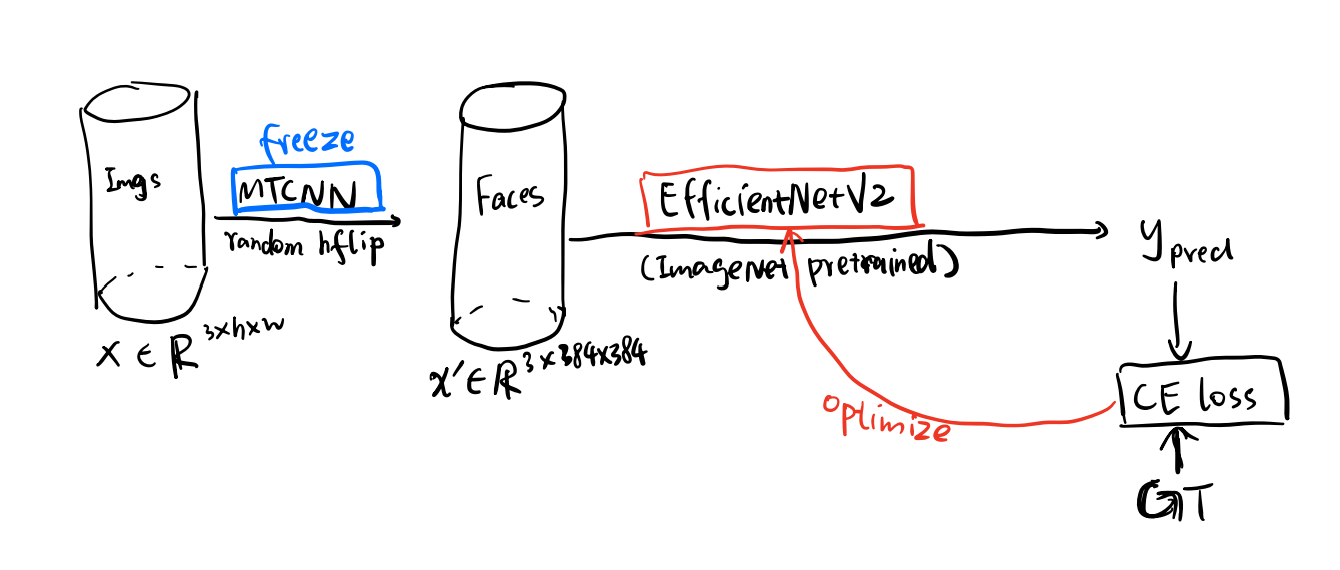

(1) **Preprocess**: Images are preprocessed by the pre-trained frozen MTCNN model. The MTCNN model takes images as input and crops the largest face from the images. If no face was detected, it will return None. In my implementation, if no face was detected, the training image or validation image will be omitted, the testing image will be the original image without cropping.

(2) **Data augmentation**: I only use random horizontal flipping.

(3) After preprocessing, data augmentation and normalization, we have images(faces) with shape bx3x384x384 as the EfficientNetV2 input, where b is the batch size.

(4) **Network**: Based on the tradeoff of FLOPs and classification performance from [Table of all available classification weights](https://pytorch.org/vision/stable/models.html), I used the [EfficientNet_V2_S_Weights.IMAGENET1K_V1](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_v2_s.html#torchvision.models.EfficientNet_V2_S_Weights)(GFLOPs	
8.37 / acc@1(on ImageNet-1K)84.228%) from Pytorch as the network initialization. To make it to classify 100 faces, I modified its last layer by "model.classifier[1] = nn.Linear(1280, 100)".

(5) **Optimizer**: Adam with default parameters.

(6) **Scheduler**: StepLR at the beginning, and later Cosine Annualing for some finetune.

(7) **Loss function**: Cross-Entropy Loss


#Preprocess training data
***Warning***[**this may take over 10 minutes!**]:
 Detect, crop and save the face. We do online face detection and cropping for test set.

In [ ]:
import cv2 
import glob
from facenet_pytorch import MTCNN
import PIL.Image as Image
import os
from tqdm import tqdm
import time
import random

mtcnn = MTCNN(margin=20, keep_all=False, post_process=False, device='cuda:0')
root = "./"
not_detected = 0
train_files = glob.glob(root+"train_small/*")
random.shuffle(train_files)
for i in tqdm(train_files):
    try:
        img = Image.open(i).convert('RGB')
    except:
        print("PIL error")
        continue
    try:
        face = mtcnn(img)
    except:
        print("mtcnn error")
        continue
    if face is None:
        print("not detected: ", i)
        with open('train_remove_list.txt', 'w') as f:
            f.write(str(i)+'\n')
        not_detected += 1
    else:
        face = face.permute(1, 2, 0).int().numpy()
        if not os.path.exists(root+'train_face'):
            os.makedirs(root+'train_face')
        cv2.imwrite(i.replace('train_small', 'train_face'), face[..., ::-1])

  3%|▎         | 175/6955 [00:29<10:43, 10.53it/s]

not detected:  ./train_small/3831.jpg


  3%|▎         | 201/6955 [00:39<17:42,  6.36it/s]

not detected:  ./train_small/178.jpg


  3%|▎         | 207/6955 [00:39<16:30,  6.81it/s]

not detected:  ./train_small/2339.jpg


  3%|▎         | 222/6955 [00:42<11:04, 10.14it/s]

not detected:  ./train_small/2173.jpg


  4%|▎         | 251/6955 [00:46<15:50,  7.06it/s]

not detected:  ./train_small/5380.jpg


  4%|▍         | 263/6955 [00:48<12:57,  8.61it/s]

not detected:  ./train_small/2435.jpg


  5%|▍         | 332/6955 [01:01<09:16, 11.91it/s]

not detected:  ./train_small/3610.jpg


  5%|▍         | 336/6955 [01:02<09:44, 11.33it/s]

not detected:  ./train_small/2837.jpg


  7%|▋         | 482/6955 [01:19<09:50, 10.96it/s]

not detected:  ./train_small/3401.jpg


  7%|▋         | 488/6955 [01:20<19:22,  5.56it/s]/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  7%|▋         | 509/6955 [01:22<11:33,  9.29it/s]

not detected:  ./train_small/2196.jpg


  8%|▊         | 543/6955 [01:26<09:45, 10.96it/s]

not detected:  ./train_small/4491.jpg


  8%|▊         | 566/6955 [01:29<10:43,  9.93it/s]

not detected:  ./train_small/3289.jpg


  9%|▊         | 604/6955 [01:33<20:20,  5.20it/s]

not detected:  ./train_small/2949.jpg


  9%|▉         | 616/6955 [01:37<12:52,  8.21it/s]

not detected:  ./train_small/4224.jpg


  9%|▉         | 644/6955 [01:41<09:24, 11.19it/s]

not detected:  ./train_small/1934.jpg


 10%|▉         | 690/6955 [01:47<17:15,  6.05it/s]

not detected:  ./train_small/964.jpg


 12%|█▏        | 861/6955 [02:14<16:52,  6.02it/s]

not detected:  ./train_small/385.jpg


 13%|█▎        | 874/6955 [02:15<11:24,  8.88it/s]

not detected:  ./train_small/400.jpg


 13%|█▎        | 883/6955 [02:16<09:19, 10.86it/s]

not detected:  ./train_small/4378.jpg


 13%|█▎        | 901/6955 [02:18<09:27, 10.67it/s]

not detected:  ./train_small/4600.jpg


 14%|█▍        | 980/6955 [02:28<08:47, 11.33it/s]

not detected:  ./train_small/2302.jpg


 15%|█▍        | 1042/6955 [02:34<10:11,  9.67it/s]

not detected:  ./train_small/1632.jpg


 15%|█▌        | 1059/6955 [02:36<14:27,  6.80it/s]

not detected:  ./train_small/6889.jpg
not detected:  ./train_small/2002.jpg


 16%|█▋        | 1140/6955 [02:49<11:28,  8.45it/s]

not detected:  ./train_small/6105.jpg


 18%|█▊        | 1242/6955 [03:00<07:23, 12.89it/s]

not detected:  ./train_small/5116.jpg


 20%|██        | 1395/6955 [03:14<08:19, 11.13it/s]

not detected:  ./train_small/4791.jpg


 20%|██        | 1408/6955 [03:19<21:12,  4.36it/s]

not detected:  ./train_small/6529.jpg


 20%|██        | 1422/6955 [03:21<08:56, 10.31it/s]

not detected:  ./train_small/6841.jpg


 21%|██        | 1466/6955 [03:24<07:44, 11.83it/s]

not detected:  ./train_small/5596.jpg


 22%|██▏       | 1503/6955 [03:29<10:30,  8.65it/s]

not detected:  ./train_small/4668.jpg


 22%|██▏       | 1507/6955 [03:29<08:37, 10.52it/s]

not detected:  ./train_small/4431.jpg


 22%|██▏       | 1533/6955 [03:32<09:31,  9.48it/s]

not detected:  ./train_small/625.jpg


 25%|██▍       | 1711/6955 [03:54<17:32,  4.98it/s]

not detected:  ./train_small/3231.jpg


 26%|██▌       | 1783/6955 [04:03<07:44, 11.12it/s]

not detected:  ./train_small/1513.jpg


 27%|██▋       | 1891/6955 [04:20<20:33,  4.11it/s]

not detected:  ./train_small/2872.jpg


 29%|██▊       | 1997/6955 [04:34<06:39, 12.40it/s]

not detected:  ./train_small/5618.jpg


 29%|██▉       | 2012/6955 [04:35<05:55, 13.92it/s]

not detected:  ./train_small/2288.jpg


 30%|███       | 2112/6955 [04:47<06:32, 12.34it/s]

not detected:  ./train_small/3737.jpg


 31%|███       | 2134/6955 [04:50<11:43,  6.85it/s]

not detected:  ./train_small/5682.jpg


 31%|███       | 2157/6955 [04:52<06:06, 13.11it/s]

not detected:  ./train_small/6506.jpg


 32%|███▏      | 2193/6955 [04:58<28:54,  2.75it/s]

not detected:  ./train_small/2425.jpg


 33%|███▎      | 2308/6955 [05:10<06:30, 11.90it/s]

not detected:  ./train_small/2786.jpg


 34%|███▎      | 2330/6955 [05:12<04:46, 16.16it/s]

not detected:  ./train_small/3187.jpg


 34%|███▍      | 2371/6955 [05:16<10:08,  7.53it/s]

not detected:  ./train_small/6619.jpg


 34%|███▍      | 2389/6955 [05:18<05:24, 14.07it/s]

not detected:  ./train_small/5120.jpg


 34%|███▍      | 2393/6955 [05:18<05:48, 13.08it/s]

not detected:  ./train_small/4343.jpg


 35%|███▍      | 2403/6955 [05:19<04:31, 16.78it/s]

not detected:  ./train_small/681.jpg


 35%|███▍      | 2423/6955 [05:22<19:32,  3.86it/s]

not detected:  ./train_small/2137.jpg


 35%|███▌      | 2455/6955 [05:26<05:06, 14.69it/s]

not detected:  ./train_small/2305.jpg


 37%|███▋      | 2540/6955 [05:34<09:47,  7.51it/s]

not detected:  ./train_small/5909.jpg


 39%|███▊      | 2680/6955 [05:50<07:39,  9.30it/s]

not detected:  ./train_small/5541.jpg


 39%|███▊      | 2682/6955 [05:50<06:49, 10.42it/s]

not detected:  ./train_small/3081.jpg


 39%|███▉      | 2736/6955 [05:55<08:02,  8.74it/s]

not detected:  ./train_small/5589.jpg


 39%|███▉      | 2747/6955 [05:59<21:47,  3.22it/s]

not detected:  ./train_small/267.jpg


 40%|███▉      | 2764/6955 [06:01<06:18, 11.06it/s]

not detected:  ./train_small/1828.jpg


 40%|████      | 2793/6955 [06:06<11:44,  5.91it/s]

not detected:  ./train_small/6839.jpg


 40%|████      | 2814/6955 [06:11<12:01,  5.74it/s]

not detected:  ./train_small/746.jpg


 41%|████      | 2834/6955 [06:14<06:56,  9.89it/s]

not detected:  ./train_small/1254.jpg


 41%|████      | 2861/6955 [06:17<05:30, 12.38it/s]

not detected:  ./train_small/6535.jpg


 42%|████▏     | 2891/6955 [06:23<13:00,  5.21it/s]

not detected:  ./train_small/5350.jpg


 44%|████▍     | 3046/6955 [06:41<04:36, 14.12it/s]

not detected:  ./train_small/4500.jpg


 44%|████▍     | 3075/6955 [06:46<06:40,  9.70it/s]

not detected:  ./train_small/1204.jpg


 44%|████▍     | 3086/6955 [06:49<10:58,  5.88it/s]

not detected:  ./train_small/3749.jpg


 45%|████▌     | 3154/6955 [06:58<04:56, 12.81it/s]

not detected:  ./train_small/6461.jpg


 46%|████▌     | 3204/6955 [07:10<06:32,  9.55it/s]

not detected:  ./train_small/2292.jpg


 47%|████▋     | 3286/6955 [07:18<03:35, 17.04it/s]

not detected:  ./train_small/1421.jpg


 48%|████▊     | 3306/6955 [07:21<08:17,  7.34it/s]

not detected:  ./train_small/2099.jpg


 48%|████▊     | 3315/6955 [07:22<06:44,  9.01it/s]

not detected:  ./train_small/691.jpg


 48%|████▊     | 3320/6955 [07:22<05:23, 11.23it/s]

not detected:  ./train_small/6442.jpg


 49%|████▉     | 3439/6955 [07:42<11:44,  4.99it/s]

not detected:  ./train_small/6269.jpg


 51%|█████     | 3536/6955 [07:54<10:23,  5.48it/s]

not detected:  ./train_small/5954.jpg


 51%|█████▏    | 3569/6955 [07:59<06:16,  8.99it/s]

not detected:  ./train_small/5722.jpg


 52%|█████▏    | 3633/6955 [08:02<03:02, 18.15it/s]

not detected:  ./train_small/5702.jpg


 53%|█████▎    | 3709/6955 [08:11<04:25, 12.24it/s]

not detected:  ./train_small/3164.jpg


 54%|█████▍    | 3745/6955 [08:14<03:36, 14.83it/s]

not detected:  ./train_small/6564.jpg


 54%|█████▍    | 3755/6955 [08:14<03:49, 13.95it/s]

not detected:  ./train_small/1750.jpg


 54%|█████▍    | 3767/6955 [08:15<03:16, 16.22it/s]

not detected:  ./train_small/722.jpg


 55%|█████▍    | 3791/6955 [08:17<05:00, 10.54it/s]

not detected:  ./train_small/1535.jpg


 55%|█████▍    | 3799/6955 [08:18<04:03, 12.94it/s]

not detected:  ./train_small/6220.jpg


 55%|█████▌    | 3837/6955 [08:22<04:34, 11.38it/s]

not detected:  ./train_small/106.jpg


 55%|█████▌    | 3844/6955 [08:23<04:02, 12.84it/s]

not detected:  ./train_small/425.jpg


 56%|█████▌    | 3898/6955 [08:29<03:56, 12.90it/s]

not detected:  ./train_small/2036.jpg


 57%|█████▋    | 3948/6955 [08:36<04:57, 10.09it/s]

not detected:  ./train_small/6513.jpg


 57%|█████▋    | 3954/6955 [08:36<04:09, 12.01it/s]

not detected:  ./train_small/597.jpg


 57%|█████▋    | 3981/6955 [08:39<04:38, 10.69it/s]

not detected:  ./train_small/1899.jpg


 59%|█████▉    | 4101/6955 [08:56<05:17,  8.98it/s]

not detected:  ./train_small/1830.jpg
not detected:  ./train_small/6275.jpg


 60%|█████▉    | 4151/6955 [09:04<06:15,  7.46it/s]

not detected:  ./train_small/5185.jpg


 60%|██████    | 4183/6955 [09:11<09:27,  4.88it/s]

not detected:  ./train_small/6382.jpg


 61%|██████▏   | 4263/6955 [09:19<03:02, 14.78it/s]

not detected:  ./train_small/1617.jpg


 63%|██████▎   | 4347/6955 [09:28<03:58, 10.93it/s]

not detected:  ./train_small/2790.jpg


 64%|██████▍   | 4462/6955 [09:41<05:31,  7.53it/s]

not detected:  ./train_small/2283.jpg


 66%|██████▌   | 4569/6955 [09:55<05:00,  7.93it/s]

not detected:  ./train_small/4516.jpg


 66%|██████▌   | 4584/6955 [09:56<03:25, 11.54it/s]

not detected:  ./train_small/2059.jpg


 66%|██████▌   | 4588/6955 [09:57<05:01,  7.84it/s]

not detected:  ./train_small/1581.jpg


 67%|██████▋   | 4649/6955 [10:02<02:42, 14.22it/s]

not detected:  ./train_small/3095.jpg


 69%|██████▊   | 4774/6955 [10:15<03:07, 11.61it/s]

not detected:  ./train_small/2871.jpg


 69%|██████▉   | 4783/6955 [10:16<03:02, 11.91it/s]

not detected:  ./train_small/3944.jpg


 70%|██████▉   | 4864/6955 [10:24<07:07,  4.89it/s]

not detected:  ./train_small/1101.jpg


 70%|███████   | 4878/6955 [10:26<03:39,  9.44it/s]

not detected:  ./train_small/296.jpg
not detected:  ./train_small/2233.jpg


 71%|███████   | 4951/6955 [10:33<04:30,  7.41it/s]

not detected:  ./train_small/5491.jpg


 72%|███████▏  | 5030/6955 [10:45<04:28,  7.16it/s]

not detected:  ./train_small/6129.jpg


 73%|███████▎  | 5065/6955 [10:49<03:48,  8.28it/s]

not detected:  ./train_small/4945.jpg


 75%|███████▍  | 5199/6955 [11:02<03:06,  9.41it/s]

not detected:  ./train_small/1207.jpg


 75%|███████▌  | 5234/6955 [11:06<02:44, 10.43it/s]

not detected:  ./train_small/5281.jpg


 76%|███████▌  | 5282/6955 [11:14<02:47,  9.96it/s]

not detected:  ./train_small/5772.jpg


 76%|███████▋  | 5304/6955 [11:16<01:59, 13.82it/s]

not detected:  ./train_small/3495.jpg


 76%|███████▋  | 5313/6955 [11:16<01:55, 14.16it/s]

not detected:  ./train_small/3570.jpg


 77%|███████▋  | 5381/6955 [11:21<02:10, 12.04it/s]

not detected:  ./train_small/1688.jpg


 78%|███████▊  | 5399/6955 [11:23<01:55, 13.50it/s]

not detected:  ./train_small/5872.jpg


 78%|███████▊  | 5432/6955 [11:26<02:00, 12.68it/s]

not detected:  ./train_small/6135.jpg


 80%|███████▉  | 5552/6955 [11:40<02:15, 10.34it/s]

not detected:  ./train_small/2419.jpg


 81%|████████  | 5628/6955 [11:47<01:44, 12.76it/s]

not detected:  ./train_small/45.jpg


 81%|████████  | 5636/6955 [11:47<01:43, 12.80it/s]

not detected:  ./train_small/5945.jpg


 81%|████████▏ | 5654/6955 [11:49<01:39, 13.09it/s]

not detected:  ./train_small/2704.jpg


 82%|████████▏ | 5727/6955 [11:56<01:34, 13.03it/s]

not detected:  ./train_small/1562.jpg


 83%|████████▎ | 5784/6955 [12:01<01:37, 11.95it/s]

not detected:  ./train_small/3197.jpg


 86%|████████▌ | 5959/6955 [12:18<02:00,  8.30it/s]

not detected:  ./train_small/6898.jpg


 86%|████████▌ | 5971/6955 [12:19<01:04, 15.20it/s]

not detected:  ./train_small/5895.jpg


 86%|████████▋ | 6007/6955 [12:21<01:01, 15.32it/s]

not detected:  ./train_small/107.jpg


 87%|████████▋ | 6027/6955 [12:23<01:14, 12.44it/s]

not detected:  ./train_small/4798.jpg


 87%|████████▋ | 6056/6955 [12:26<02:10,  6.87it/s]

not detected:  ./train_small/5440.jpg


 88%|████████▊ | 6140/6955 [12:36<01:19, 10.24it/s]

not detected:  ./train_small/3490.jpg


 88%|████████▊ | 6153/6955 [12:37<00:58, 13.61it/s]

not detected:  ./train_small/5833.jpg


 89%|████████▉ | 6216/6955 [12:43<00:46, 15.74it/s]

not detected:  ./train_small/882.jpg
not detected:  ./train_small/307.jpg


 90%|████████▉ | 6228/6955 [12:45<01:01, 11.75it/s]

not detected:  ./train_small/5254.jpg


 91%|█████████ | 6334/6955 [12:58<00:56, 10.97it/s]

not detected:  ./train_small/5367.jpg


 91%|█████████▏| 6354/6955 [12:59<00:51, 11.69it/s]

not detected:  ./train_small/3010.jpg


 92%|█████████▏| 6366/6955 [13:00<00:38, 15.20it/s]

not detected:  ./train_small/1760.jpg


 92%|█████████▏| 6396/6955 [13:04<01:58,  4.72it/s]

not detected:  ./train_small/3093.jpg


 92%|█████████▏| 6414/6955 [13:06<00:41, 13.12it/s]

not detected:  ./train_small/6503.jpg


 92%|█████████▏| 6422/6955 [13:07<00:46, 11.44it/s]

not detected:  ./train_small/3378.jpg


 94%|█████████▍| 6531/6955 [13:16<00:38, 10.99it/s]

not detected:  ./train_small/596.jpg


 95%|█████████▌| 6631/6955 [13:28<00:20, 16.09it/s]

not detected:  ./train_small/5245.jpg


 96%|█████████▌| 6663/6955 [13:32<00:41,  7.05it/s]

not detected:  ./train_small/6938.jpg


 96%|█████████▌| 6669/6955 [13:32<00:27, 10.51it/s]

not detected:  ./train_small/2958.jpg


 97%|█████████▋| 6723/6955 [13:37<00:19, 11.87it/s]

not detected:  ./train_small/3632.jpg


 98%|█████████▊| 6816/6955 [13:47<00:17,  8.01it/s]

not detected:  ./train_small/4497.jpg


100%|█████████▉| 6945/6955 [13:58<00:00, 12.33it/s]

not detected:  ./train_small/151.jpg


100%|██████████| 6955/6955 [13:59<00:00,  8.29it/s]


In [ ]:
!nvidia-smi

Sat Apr 22 23:27:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    31W /  70W |   4041MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Cropped Face Samples

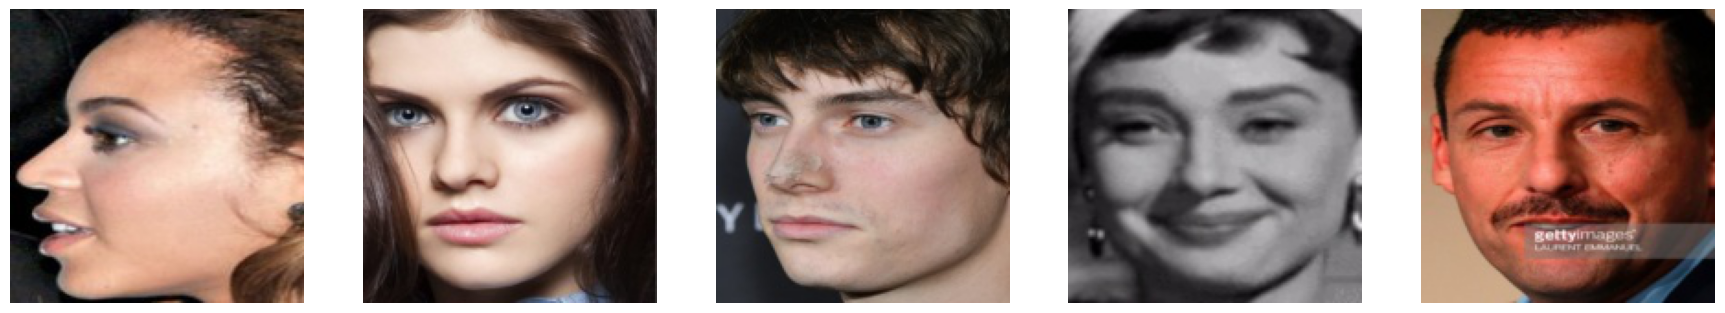

In [ ]:
import matplotlib.pyplot as plt
import os, random

directory = './train_face/'
image_list = os.listdir(directory)
random.shuffle(image_list)

fig, axs = plt.subplots(1, 5, figsize=(22, 22))
cnt = 0
for i in range(5):
      gen_imgs = plt.imread(directory+image_list[i])
      axs[i].imshow(gen_imgs)
      axs[i].axis('off')
      # cnt += 1
plt.show()

#@utils

(1)convert numpy.ndarray to torch tensor
(2)convert torch tensor to images that cv2 can use


In [ ]:
import torch
import numpy as np
import cv2

def _is_numpy_image(img):
    return isinstance(img, np.ndarray) and (img.ndim in {2, 3})

def to_tensor(img):
    '''convert numpy.ndarray to torch tensor. \n
        if the image is uint8 , it will be divided by 255;\n
        if the image is uint16 , it will be divided by 65535;\n
        if the image is float , it will not be divided, we suppose your image range should between [0~1] ;\n
    
    Arguments:
        img {numpy.ndarray} -- image to be converted to tensor.
    '''
    if not _is_numpy_image(img):
        raise TypeError('data should be numpy ndarray. but got {}'.format(type(img)))

    if img.ndim == 2:
        img = img[:, :, None]

    if img.dtype == np.uint8:
        img = img.astype(np.float32)/255
    elif img.dtype == np.uint16:
        img = img.astype(np.float32)/65535
    elif img.dtype in [np.float32, np.float64]:
        img = img.astype(np.float32)/1
    else:
        raise TypeError('{} is not support'.format(img.dtype))
    
    img = torch.from_numpy(img.transpose((2, 0, 1)))

    return img

def tensor2img(tensor, rgb2bgr=True, out_type=np.uint8, min_max=(0, 1)):
    """Convert torch Tensors into image numpy arrays.
    After clamping to [min, max], values will be normalized to [0, 1].
    Args:
        tensor (Tensor or list[Tensor]): Accept shapes:
            1) 4D mini-batch Tensor of shape (B x 3/1 x H x W);
            2) 3D Tensor of shape (3/1 x H x W);
            3) 2D Tensor of shape (H x W).
            Tensor channel should be in RGB order.
        rgb2bgr (bool): Whether to change rgb to bgr.
        out_type (numpy type): output types. If ``np.uint8``, transform outputs
            to uint8 type with range [0, 255]; otherwise, float type with
            range [0, 1]. Default: ``np.uint8``.
        min_max (tuple[int]): min and max values for clamp.
    Returns:
        (Tensor or list): 3D ndarray of shape (H x W x C) OR 2D ndarray of
        shape (H x W). The channel order is BGR.
    """
    if not (torch.is_tensor(tensor) or (isinstance(tensor, list) and all(torch.is_tensor(t) for t in tensor))):
        raise TypeError(f'tensor or list of tensors expected, got {type(tensor)}')

    if torch.is_tensor(tensor):
        tensor = [tensor]
    result = []
    for _tensor in tensor:
        _tensor = _tensor.squeeze(0).float().detach().cpu().clamp_(*min_max)
        _tensor = (_tensor - min_max[0]) / (min_max[1] - min_max[0])

        n_dim = _tensor.dim()
        if n_dim == 3:
            img_np = _tensor.numpy()
            img_np = img_np.transpose(1, 2, 0)
            if img_np.shape[2] == 1:  # gray image
                img_np = np.squeeze(img_np, axis=2)
            else:
                if rgb2bgr:
                    img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
        elif n_dim == 2:
            img_np = _tensor.numpy()
        else:
            raise TypeError(f'Only support 3D or 2D tensor. But received with dimension: {n_dim}')
        if out_type == np.uint8:
            img_np = (img_np * 255.0).round()
        img_np = img_np.astype(out_type)
        result.append(img_np)
    if len(result) == 1:
        result = result[0]
    return result


#@schedulers

define a CosineAnnealingRestartLR learning scheduler

In [ ]:
from torch.optim.lr_scheduler import _LRScheduler
import math
from collections import Counter


def get_position_from_periods(iteration, cumulative_period):
    """Get the position from a period list.
    It will return the index of the right-closest number in the period list.
    For example, the cumulative_period = [100, 200, 300, 400],
    if iteration == 50, return 0;
    if iteration == 210, return 2;
    if iteration == 300, return 2.
    Args:
        iteration (int): Current iteration.
        cumulative_period (list[int]): Cumulative period list.
    Returns:
        int: The position of the right-closest number in the period list.
    """
    for i, period in enumerate(cumulative_period):
        if iteration <= period:
            return i


class CosineAnnealingRestartLR(_LRScheduler):
    """ Cosine annealing with restarts learning rate scheme.
    An example of config:
    periods = [10, 10, 10, 10]
    restart_weights = [1, 0.5, 0.5, 0.5]
    eta_min=1e-7
    It has four cycles, each has 10 iterations. At 10th, 20th, 30th, the
    scheduler will restart with the weights in restart_weights.
    Args:
        optimizer (torch.nn.optimizer): Torch optimizer.
        periods (list): Period for each cosine anneling cycle.
        restart_weights (list): Restart weights at each restart iteration.
            Default: [1].
        eta_min (float): The mimimum lr. Default: 0.
        last_epoch (int): Used in _LRScheduler. Default: -1.
    """

    def __init__(self, optimizer, periods, restart_weights=(1, ), eta_min=0, last_epoch=-1):
        self.periods = periods
        self.restart_weights = restart_weights
        self.eta_min = eta_min
        assert (len(self.periods) == len(
            self.restart_weights)), 'periods and restart_weights should have the same length.'
        self.cumulative_period = [sum(self.periods[0:i + 1]) for i in range(0, len(self.periods))]
        super(CosineAnnealingRestartLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        idx = get_position_from_periods(self.last_epoch, self.cumulative_period)
        current_weight = self.restart_weights[idx]
        nearest_restart = 0 if idx == 0 else self.cumulative_period[idx - 1]
        current_period = self.periods[idx]

        return [
            self.eta_min + current_weight * 0.5 * (base_lr - self.eta_min) *
            (1 + math.cos(math.pi * ((self.last_epoch - nearest_restart) / current_period)))
            for base_lr in self.base_lrs
        ]


#@Dataloader

In [ ]:
import random
import torch
from torch.utils.data import Dataset
import glob
from PIL import Image
import torchvision.transforms.functional as TF
from facenet_pytorch import fixed_image_standardization, MTCNN
import csv
import cv2
import os


class Celeb70K(Dataset):
    def __init__(self, root="./", val_rate=0.15, mode='train', transform=None):
        if mode=="test":
            self.mtcnn = MTCNN(margin=20, keep_all=False, post_process=False, device='cuda:0')
        self.root = root
        self.mode = mode
        self.transform = transform
        train_files = glob.glob(self.root+'train_face/*')
        length = len(train_files)
        # Train Val Split
        self.cut_index = int(length*val_rate)
        if mode == 'train':
            self.input_files = train_files[self.cut_index:]
            self.len = length-self.cut_index
        elif mode == 'val':
            self.input_files = train_files[:self.cut_index]
            self.len = self.cut_index
        # Generate Test set paths
        elif mode == 'test':
            self.input_files = []
            for i in range(0, 4977):
                self.input_files.append(self.root+'test/'+str(i)+'.jpg')
            self.len = len(self.input_files)

        # Category Labels
        with open('category.csv','r') as f:
            self.labels = f.readlines()[1:]
        self.labels = [l.split(',')[1] for l in self.labels]
        self.labels = [l[:-1] for l in self.labels]

        # Create Training Label-ImgName Mapping
        with open('train_small.csv','r') as f:
            self.trian_labels = f.readlines()[1:]
        self.train_dict = {}
        for l in self.trian_labels:
            self.train_dict[l.split(',')[1]]=l.split(',')[2][:-1]

    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        img_name = self.input_files[index].split('/')[-1]
        # convert Gray or RGBA images to RGB
        if self.transform is None:
            img_input = Image.open(self.input_files[index]).convert('RGB').resize((160, 160))
        else:
            img_input = Image.open(self.input_files[index]).convert('RGB')
        
        if self.mode == "test":
            gt = 0
        else:
            # get the index of the label by retrieving label from the pre-defined mapping dictionary
            gt = self.labels.index(self.train_dict[img_name])
        gt = torch.LongTensor([gt])
        
        # Augmentation: Random horizontal flip
        if self.mode == "train":
            hflip = random.random()
            if hflip > 0.5:
                img_input = img_input.transpose(Image.FLIP_LEFT_RIGHT)
            
        if self.mode == "test":
            # Online Face Detection for test set
            face = self.mtcnn(img_input)
            if face is not None:
                img_input = face/255
            else:
                img_input = TF.to_tensor(img_input)
        else:
            img_input = TF.to_tensor(img_input)

        # Data Normalization
        if self.transform is None:
            img_input = fixed_image_standardization(img_input)
        else:
            img_input = self.transform(img_input)

        return {"img_name": img_name, "img_input": img_input, "gt": gt}


# Training & Testing


import necessary packages

In [ ]:
import os
import random
import argparse
from tqdm import tqdm
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
import pandas as pd

from facenet_pytorch import InceptionResnetV1
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(13)
random.seed(13)

Define the Trainer, it supports training, validation, testing.

In [ ]:
class Trainer:
    def __init__(self):
        # parser add arguments to support running the code with different parameter setting without modifying the code
        parser = argparse.ArgumentParser()
        parser.add_argument("--epoch", type=int, default=0, help="epoch to start \
                                        training from, 0 starts from scratch, >0 starts from saved checkpoints")#
        parser.add_argument("--n_epochs", type=int, default=100, help="total number of epochs of training")
        parser.add_argument("--lr_decay", type=float, default=0.5, help="learning rate decay factor")
        parser.add_argument("--step_size", type=int, default=20, help="learning rate decay step size")
        parser.add_argument("--batch_size", type=int, default=32, help="size of the batches")
        parser.add_argument("--lr", type=float, default=1e-3, help="adam: learning rate")
        parser.add_argument("--ckpt_interval", type=int, default=1, help="interval between model checkpoints")
        parser.add_argument("--log_interval", type=int, default=200, help="interval between print logs")
        parser.add_argument("--output_dir", type=str, default="results", help="path to save model and images")
        parser.add_argument("--log_name", type=str, default="train_log", help="log file name")#
        parser.add_argument("--tensorboard", type=str, default="train_tb", help="tb file name")#
        parser.add_argument("--root", type=str, default="./", help="root path")
        parser.add_argument("--mode", type=str, default="train", help="train/val/test")#
        parser.add_argument("--scheduler", type=str, default="step", help="cosine/step")
        parser.add_argument("--model", type=str, default="efficientnet", help="facenet/resnet/maxvit/regnet/swin/efficientnet")

        self.opt, unknown = parser.parse_known_args()
        self.device = torch.device("cuda")
        self.eps = 1e-6
        self.opt.n_cpu = self.opt.batch_size//8

        # define the data normalization for EfficientNetV2 as described there 
        # (https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_v2_s.html#torchvision.models.efficientnet_v2_s)
        transform = torchvision.transforms.Compose([torchvision.transforms.Resize(size=(224, 224), interpolation=torchvision.transforms.InterpolationMode.BICUBIC), 
                                                        torchvision.transforms.CenterCrop(224),
                                                        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                        std=[0.229, 0.224, 0.225])])
        if self.opt.model == "efficientnet":
            self.transform = transform
        else:
            self.transform = None

        if self.opt.mode != "test":
            # train dataloader
            self.train_dataset = Celeb70K(mode='train', transform=self.transform)
            self.train_loader = DataLoader(self.train_dataset, batch_size=self.opt.batch_size, 
                                            shuffle=True, num_workers=self.opt.n_cpu, drop_last=False, pin_memory=True)
            # tensorboard
            self.writer = SummaryWriter(os.path.join(self.opt.root, self.opt.output_dir, 'logs', self.opt.tensorboard))
        
        # validation / test dataloader
        val_dataset = Celeb70K(mode='val', transform=self.transform)
        self.val_loader = DataLoader(val_dataset, batch_size=self.opt.batch_size, shuffle=False, num_workers=self.opt.n_cpu, drop_last=False, pin_memory=True)
        test_dataset = Celeb70K(mode='test', transform=self.transform)
        self.test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)

        # initialize model, optimizer, scheduler, loss function
        self.init_model_optimizer()
        # load model to GPU, dataparallel model
        self.prep_model()

    def init_model_optimizer(self):
        # loss function
        self.criterion = nn.CrossEntropyLoss()

        # initialize models
        if self.opt.model == "facenet":
            self.model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=100)
        elif self.opt.model == "efficientnet":
            self.model = torchvision.models.efficientnet_v2_s(weights = 'IMAGENET1K_V1')
            self.model.classifier[1] = nn.Linear(1280, 100)

        # optimizer and scheduler
        if self.opt.mode == "train":
            self.optimizer = Adam(self.model.parameters(), lr=self.opt.lr)
            if self.opt.scheduler == "step":
                self.scheduler = StepLR(self.optimizer, step_size=self.opt.step_size, gamma=self.opt.lr_decay)
            elif self.opt.scheduler == "cosine":
                period = self.opt.n_epochs // 5
                self.scheduler = CosineAnnealingRestartLR(
                    self.optimizer,
                    periods=[period, period, period, period, period],
                    restart_weights=[1, 1, 1, 1, 1],
                    eta_min=1e-5,
                    last_epoch=-1,
                )
        # initialize max accuracy and the corresponding epoch for validation and pick up the best model for testing.
        self.max_acc, self.max_epoch = 0, 0
    
    def prep_model(self):
        # to GPU, dataparallel
        self.model = self.model.to(self.device)
        self.model = nn.DataParallel(self.model)

        # load pretrain to resume training
        if self.opt.epoch!=0:
            self.load_model(self.opt.epoch)
        
        # model parameter trainable
        self.model.train()
    
    def load_model(self, e):
        self.model.load_state_dict(torch.load(os.path.join(self.opt.root, self.opt.output_dir, 
                    'ckpts', self.opt.log_name, 'model_' + str(int(e)) + ".pth")))

    def inference(self, img):
        pred = self.model(img)
        return pred

    def train_a_epoch(self, e, data_loader):
        loss_print=0
        self.model.train()

        for i, train_data in enumerate(tqdm(data_loader)):
            self.optimizer.zero_grad()
            
            # load input and GT
            img = train_data["img_input"].to(self.device)
            gt = train_data["gt"].to(self.device)

            # inference
            pred = self.inference(img)

            # loss function, backpropogation
            loss = self.criterion(pred, gt.squeeze(1))
            loss.backward()
            loss_print+=loss.item()
            self.optimizer.step()

            # output logs
            if (i+1) % self.opt.log_interval == 0:
                self.writer.add_scalar("Loss/train", loss_print/self.opt.log_interval, i+e*len(data_loader))
                print(self.optimizer.param_groups[-1]['lr'], e, i, ': ', loss_print/self.opt.log_interval)
                with open('./results/logs/'+self.opt.log_name+'.txt', 'a') as f:
                    f.write("train: lr %.8f|%d|%d|%4.7f\n"%(self.optimizer.param_groups[-1]['lr'], e, i, loss_print/self.opt.log_interval))
                loss_print=0.0

        # validation, save checkpoint  
        if e % self.opt.ckpt_interval == 0:
            # validation
            best_epoch = self.validate(e, self.val_loader)
            if best_epoch==e:
                ckpt_model_filename = 'model_' + str(e) + ".pth"
                ckpt_model_path = os.path.join(self.opt.root, self.opt.output_dir, 
                                                'ckpts', self.opt.log_name, ckpt_model_filename)
                directory = os.path.join(self.opt.root, self.opt.output_dir, 'ckpts', self.opt.log_name)
                if not os.path.exists(directory):
                    Path(directory).mkdir(parents=True, exist_ok=True)

                state = self.model.state_dict()
                torch.save(state, ckpt_model_path)
                print("model saved to %s" % ckpt_model_path)
            self.scheduler.step()

        self.writer.close()   
        return best_epoch     
    
    def train(self):
        if self.opt.mode == "train":
            # train n_epochs
            for e in range(1, int(self.opt.n_epochs)+1):
                best_epoch = self.train_a_epoch(e, self.train_loader)
                
            # final test
            self.test(best_epoch, file_name=self.opt.log_name)

        elif self.opt.mode == "test":
            # load model and test
            self.load_model(self.opt.epoch)
            print("test start")
            self.test(self.opt.epoch, file_name=self.opt.log_name)
            print("test end")
        
        else:
            # pure validation, typically we don't use this mode
            for e in range(60, 161):
                self.load_model(e)
                print("validation %d start", e)
                self.validate(self.opt.epoch, self.train_loader)
                print("validation %d end", e)

    # validation, update the best validation accuracy, the corresponding epoch
    def validate(self, e, val_loader):
        self.model.eval()

        with torch.no_grad():
            label_total = []
            output_total = []
            for i, val_data in enumerate(tqdm(val_loader)):
                img = val_data["img_input"].to(self.device)
                gt = val_data["gt"].to(self.device)
                pred = self.inference(img)
                pred = F.softmax(pred, dim=1)
                prediction = [int(torch.argmax(output).cpu()) for output in pred]
                labels = [int(label.cpu()) for label in gt]
                label_total = label_total + labels
                output_total = output_total + prediction

            acc = accuracy_score(label_total, output_total)
            print("val acc: ", acc)

            if self.max_acc<acc:
                self.max_acc = acc
                self.max_epoch = e
            print("Best: %f %d/%d"%(self.max_acc, self.max_epoch, e))
            
            with open('./results/logs/'+self.opt.log_name+'.txt', 'a') as f:
                f.write("Current: %f |EP %d \n"%(acc, e))
                f.write("Best: %f %d |EP %d \n"%(self.max_acc, self.max_epoch, e))
        
        self.model.train()
        return self.max_epoch

    # test based on the given epoch, save test results into a csv file
    def test(self, e, file_name):
        with open('category.csv','r') as f:
            self.labels = f.readlines()[1:]
        self.labels = [l.split(',')[1] for l in self.labels]
        self.labels = [l[:-1] for l in self.labels]
        with torch.no_grad():
            self.load_model(e)
            self.model.eval()
            prediction_id = []
            prediction_name = []
            for _, test_data in enumerate(tqdm(self.test_loader)):
                img = test_data["img_input"].to(self.device)
                img_name = test_data["img_name"][0]
                pred = self.inference(img)
                pred = F.softmax(pred, dim=1)
                pred_id = [int(torch.argmax(output).cpu()) for output in pred][0]
                prediction_id.append(self.labels[pred_id])
                prediction_name.append(img_name[:-4])
            
            csv = {'Id': prediction_name, 'Category': prediction_id}  
            df = pd.DataFrame(csv)
            df.to_csv('./results/logs/'+file_name+'.csv')
            print("test done")        



Trainer.train will automatically finish the whole training, validation, and final testing.

In [ ]:
if __name__ == '__main__':
    Trainer = Trainer()
    Trainer.train()


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 205MB/s]
100%|██████████| 32/32 [00:06<00:00,  4.60it/s]


val acc:  0.09990205680705191
Best: 0.099902 1/1
model saved to ./results/ckpts/train_log/model_1.pth


100%|██████████| 32/32 [00:07<00:00,  4.40it/s]


val acc:  0.3095004897159647
Best: 0.309500 2/2
model saved to ./results/ckpts/train_log/model_2.pth


100%|██████████| 32/32 [00:05<00:00,  5.79it/s]


val acc:  0.4593535749265426
Best: 0.459354 3/3
model saved to ./results/ckpts/train_log/model_3.pth


100%|██████████| 32/32 [00:05<00:00,  5.52it/s]


val acc:  0.5700293829578844
Best: 0.570029 4/4
model saved to ./results/ckpts/train_log/model_4.pth


100%|██████████| 32/32 [00:06<00:00,  5.21it/s]


val acc:  0.6385896180215475
Best: 0.638590 5/5
model saved to ./results/ckpts/train_log/model_5.pth


100%|██████████| 32/32 [00:06<00:00,  4.77it/s]


val acc:  0.7238001958863859
Best: 0.723800 6/6
model saved to ./results/ckpts/train_log/model_6.pth


100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


val acc:  0.77179236043095
Best: 0.771792 7/7
model saved to ./results/ckpts/train_log/model_7.pth


100%|██████████| 32/32 [00:06<00:00,  4.79it/s]


val acc:  0.8334965719882468
Best: 0.833497 8/8
model saved to ./results/ckpts/train_log/model_8.pth


100%|██████████| 32/32 [00:05<00:00,  5.51it/s]


val acc:  0.8285994123408423
Best: 0.833497 8/9


100%|██████████| 32/32 [00:05<00:00,  5.41it/s]


val acc:  0.8579823702252694
Best: 0.857982 10/10
model saved to ./results/ckpts/train_log/model_10.pth


100%|██████████| 32/32 [00:06<00:00,  5.28it/s]


val acc:  0.9030362389813908
Best: 0.903036 11/11
model saved to ./results/ckpts/train_log/model_11.pth


100%|██████████| 32/32 [00:07<00:00,  4.56it/s]


val acc:  0.8922624877571009
Best: 0.903036 11/12


100%|██████████| 32/32 [00:06<00:00,  4.84it/s]


val acc:  0.8991185112634672
Best: 0.903036 11/13


100%|██████████| 32/32 [00:05<00:00,  5.50it/s]


val acc:  0.910871694417238
Best: 0.910872 14/14
model saved to ./results/ckpts/train_log/model_14.pth


100%|██████████| 32/32 [00:05<00:00,  5.50it/s]


val acc:  0.9079333986287953
Best: 0.910872 14/15


100%|██████████| 32/32 [00:06<00:00,  4.97it/s]


val acc:  0.9020568070519099
Best: 0.910872 14/16


100%|██████████| 32/32 [00:07<00:00,  4.51it/s]


val acc:  0.9196865817825661
Best: 0.919687 17/17
model saved to ./results/ckpts/train_log/model_17.pth


100%|██████████| 32/32 [00:06<00:00,  4.66it/s]


val acc:  0.9245837414299706
Best: 0.924584 18/18
model saved to ./results/ckpts/train_log/model_18.pth


100%|██████████| 32/32 [00:05<00:00,  5.41it/s]


val acc:  0.9245837414299706
Best: 0.924584 18/19


100%|██████████| 32/32 [00:05<00:00,  5.57it/s]


val acc:  0.9363369245837414
Best: 0.936337 20/20
model saved to ./results/ckpts/train_log/model_20.pth


100%|██████████| 32/32 [00:05<00:00,  5.38it/s]


val acc:  0.951028403525955
Best: 0.951028 21/21
model saved to ./results/ckpts/train_log/model_21.pth


100%|██████████| 32/32 [00:06<00:00,  4.68it/s]


val acc:  0.9490695396669931
Best: 0.951028 21/22


100%|██████████| 32/32 [00:06<00:00,  4.60it/s]


val acc:  0.9520078354554359
Best: 0.952008 23/23
model saved to ./results/ckpts/train_log/model_23.pth


100%|██████████| 32/32 [00:06<00:00,  5.14it/s]


val acc:  0.9490695396669931
Best: 0.952008 23/24


100%|██████████| 32/32 [00:05<00:00,  5.41it/s]


val acc:  0.9529872673849168
Best: 0.952987 25/25
model saved to ./results/ckpts/train_log/model_25.pth


100%|██████████| 32/32 [00:05<00:00,  5.45it/s]


val acc:  0.9500489715964741
Best: 0.952987 25/26


100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


val acc:  0.9539666993143977
Best: 0.953967 27/27
model saved to ./results/ckpts/train_log/model_27.pth


100%|██████████| 32/32 [00:06<00:00,  4.63it/s]


val acc:  0.9539666993143977
Best: 0.953967 27/28


100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


val acc:  0.9461312438785504
Best: 0.953967 27/29


100%|██████████| 32/32 [00:05<00:00,  5.64it/s]


val acc:  0.9490695396669931
Best: 0.953967 27/30


100%|██████████| 32/32 [00:05<00:00,  5.40it/s]


val acc:  0.951028403525955
Best: 0.953967 27/31


100%|██████████| 32/32 [00:06<00:00,  5.05it/s]


val acc:  0.9451518119490695
Best: 0.953967 27/32


100%|██████████| 32/32 [00:07<00:00,  4.53it/s]


val acc:  0.9461312438785504
Best: 0.953967 27/33


100%|██████████| 32/32 [00:06<00:00,  4.66it/s]


val acc:  0.9373163565132223
Best: 0.953967 27/34


100%|██████████| 32/32 [00:06<00:00,  5.32it/s]


val acc:  0.9285014691478942
Best: 0.953967 27/35


100%|██████████| 32/32 [00:05<00:00,  5.49it/s]


val acc:  0.9500489715964741
Best: 0.953967 27/36


100%|██████████| 32/32 [00:05<00:00,  5.41it/s]


val acc:  0.9441723800195886
Best: 0.953967 27/37


100%|██████████| 32/32 [00:06<00:00,  4.58it/s]


val acc:  0.9461312438785504
Best: 0.953967 27/38


100%|██████████| 32/32 [00:06<00:00,  4.64it/s]


val acc:  0.9529872673849168
Best: 0.953967 27/39


100%|██████████| 32/32 [00:06<00:00,  5.33it/s]


val acc:  0.9490695396669931
Best: 0.953967 27/40


100%|██████████| 32/32 [00:05<00:00,  5.57it/s]


val acc:  0.9549461312438785
Best: 0.954946 41/41
model saved to ./results/ckpts/train_log/model_41.pth


100%|██████████| 32/32 [00:05<00:00,  5.66it/s]


val acc:  0.9490695396669931
Best: 0.954946 41/42


100%|██████████| 32/32 [00:06<00:00,  4.82it/s]


val acc:  0.9520078354554359
Best: 0.954946 41/43


100%|██████████| 32/32 [00:06<00:00,  4.59it/s]


val acc:  0.9490695396669931
Best: 0.954946 41/44


100%|██████████| 32/32 [00:06<00:00,  4.62it/s]


val acc:  0.9520078354554359
Best: 0.954946 41/45


100%|██████████| 32/32 [00:05<00:00,  5.44it/s]


val acc:  0.9529872673849168
Best: 0.954946 41/46


100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


val acc:  0.9500489715964741
Best: 0.954946 41/47


100%|██████████| 32/32 [00:05<00:00,  5.39it/s]


val acc:  0.9520078354554359
Best: 0.954946 41/48


100%|██████████| 32/32 [00:06<00:00,  4.69it/s]


val acc:  0.951028403525955
Best: 0.954946 41/49


100%|██████████| 32/32 [00:06<00:00,  4.70it/s]


val acc:  0.9490695396669931
Best: 0.954946 41/50


100%|██████████| 32/32 [00:05<00:00,  5.46it/s]


val acc:  0.9461312438785504
Best: 0.954946 41/51


100%|██████████| 32/32 [00:05<00:00,  5.48it/s]


val acc:  0.9490695396669931
Best: 0.954946 41/52


100%|██████████| 32/32 [00:05<00:00,  5.45it/s]


val acc:  0.9461312438785504
Best: 0.954946 41/53


100%|██████████| 32/32 [00:06<00:00,  5.01it/s]


val acc:  0.9490695396669931
Best: 0.954946 41/54


100%|██████████| 32/32 [00:06<00:00,  4.58it/s]


val acc:  0.9441723800195886
Best: 0.954946 41/55


100%|██████████| 32/32 [00:06<00:00,  4.74it/s]


val acc:  0.9471106758080313
Best: 0.954946 41/56


100%|██████████| 32/32 [00:05<00:00,  5.72it/s]


val acc:  0.9500489715964741
Best: 0.954946 41/57


100%|██████████| 32/32 [00:05<00:00,  5.59it/s]


val acc:  0.9461312438785504
Best: 0.954946 41/58


100%|██████████| 32/32 [00:06<00:00,  5.16it/s]


val acc:  0.951028403525955
Best: 0.954946 41/59


100%|██████████| 32/32 [00:06<00:00,  4.73it/s]


val acc:  0.9500489715964741
Best: 0.954946 41/60


100%|██████████| 32/32 [00:06<00:00,  5.07it/s]


val acc:  0.9500489715964741
Best: 0.954946 41/61


100%|██████████| 32/32 [00:05<00:00,  5.84it/s]


val acc:  0.9529872673849168
Best: 0.954946 41/62


100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


val acc:  0.9520078354554359
Best: 0.954946 41/63


100%|██████████| 32/32 [00:06<00:00,  4.68it/s]


val acc:  0.9529872673849168
Best: 0.954946 41/64


100%|██████████| 32/32 [00:06<00:00,  4.80it/s]


val acc:  0.9529872673849168
Best: 0.954946 41/65


100%|██████████| 32/32 [00:05<00:00,  5.61it/s]


val acc:  0.951028403525955
Best: 0.954946 41/66


100%|██████████| 32/32 [00:05<00:00,  5.74it/s]


val acc:  0.9529872673849168
Best: 0.954946 41/67


100%|██████████| 32/32 [00:05<00:00,  5.43it/s]


val acc:  0.9539666993143977
Best: 0.954946 41/68


100%|██████████| 32/32 [00:06<00:00,  4.80it/s]


val acc:  0.9529872673849168
Best: 0.954946 41/69


100%|██████████| 32/32 [00:06<00:00,  4.79it/s]


val acc:  0.9529872673849168
Best: 0.954946 41/70


100%|██████████| 32/32 [00:05<00:00,  5.81it/s]


val acc:  0.9520078354554359
Best: 0.954946 41/71


100%|██████████| 32/32 [00:05<00:00,  5.85it/s]


val acc:  0.9500489715964741
Best: 0.954946 41/72


100%|██████████| 32/32 [00:06<00:00,  5.06it/s]


val acc:  0.9520078354554359
Best: 0.954946 41/73


100%|██████████| 32/32 [00:06<00:00,  4.74it/s]


val acc:  0.9520078354554359
Best: 0.954946 41/74


100%|██████████| 32/32 [00:05<00:00,  5.45it/s]


val acc:  0.9490695396669931
Best: 0.954946 41/75


100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


val acc:  0.9529872673849168
Best: 0.954946 41/76


100%|██████████| 32/32 [00:05<00:00,  5.67it/s]


val acc:  0.9520078354554359
Best: 0.954946 41/77


100%|██████████| 32/32 [00:06<00:00,  4.80it/s]


val acc:  0.9520078354554359
Best: 0.954946 41/78


100%|██████████| 32/32 [00:06<00:00,  4.86it/s]


val acc:  0.951028403525955
Best: 0.954946 41/79


100%|██████████| 32/32 [00:05<00:00,  5.80it/s]


val acc:  0.9520078354554359
Best: 0.954946 41/80


100%|██████████| 32/32 [00:05<00:00,  5.68it/s]


val acc:  0.9520078354554359
Best: 0.954946 41/81


100%|██████████| 32/32 [00:05<00:00,  5.41it/s]


val acc:  0.9520078354554359
Best: 0.954946 41/82


100%|██████████| 32/32 [00:06<00:00,  4.77it/s]


val acc:  0.9500489715964741
Best: 0.954946 41/83


100%|██████████| 32/32 [00:06<00:00,  4.88it/s]


val acc:  0.951028403525955
Best: 0.954946 41/84


100%|██████████| 32/32 [00:05<00:00,  5.83it/s]


val acc:  0.9520078354554359
Best: 0.954946 41/85


100%|██████████| 32/32 [00:05<00:00,  5.75it/s]


val acc:  0.9529872673849168
Best: 0.954946 41/86


100%|██████████| 32/32 [00:06<00:00,  5.09it/s]


val acc:  0.9520078354554359
Best: 0.954946 41/87


100%|██████████| 32/32 [00:06<00:00,  4.65it/s]


val acc:  0.951028403525955
Best: 0.954946 41/88


100%|██████████| 32/32 [00:06<00:00,  5.03it/s]


val acc:  0.9480901077375122
Best: 0.954946 41/89


100%|██████████| 32/32 [00:05<00:00,  5.77it/s]


val acc:  0.951028403525955
Best: 0.954946 41/90


100%|██████████| 32/32 [00:05<00:00,  5.57it/s]


val acc:  0.9529872673849168
Best: 0.954946 41/91


100%|██████████| 32/32 [00:06<00:00,  5.26it/s]


val acc:  0.9529872673849168
Best: 0.954946 41/92


100%|██████████| 32/32 [00:06<00:00,  4.67it/s]


val acc:  0.9500489715964741
Best: 0.954946 41/93


100%|██████████| 32/32 [00:06<00:00,  4.66it/s]


val acc:  0.9529872673849168
Best: 0.954946 41/94


100%|██████████| 32/32 [00:06<00:00,  5.27it/s]


val acc:  0.9520078354554359
Best: 0.954946 41/95


100%|██████████| 32/32 [00:05<00:00,  5.48it/s]


val acc:  0.951028403525955
Best: 0.954946 41/96


100%|██████████| 32/32 [00:05<00:00,  5.76it/s]


val acc:  0.9520078354554359
Best: 0.954946 41/97


100%|██████████| 32/32 [00:06<00:00,  4.82it/s]


val acc:  0.9500489715964741
Best: 0.954946 41/98


100%|██████████| 32/32 [00:06<00:00,  4.67it/s]


val acc:  0.951028403525955
Best: 0.954946 41/99


100%|██████████| 32/32 [00:06<00:00,  4.72it/s]


val acc:  0.9490695396669931
Best: 0.954946 41/100


100%|██████████| 4977/4977 [11:00<00:00,  7.53it/s]


test done


#Show 100 Test Predictions 

The model was trained on the small train set

In [ ]:
! ls ./results/
! ls ./results/logs/

ckpts  logs
train_log.csv  train_log.txt  train_tb


In [ ]:
predictions = pd.read_csv('./results/logs/train_log.csv')
predictions.head(100)

,Unnamed: 0,Id,Category
0,0,0,Bill Hader
1,1,1,Amy Ryan
2,2,2,Adrien Brody
3,3,3,Adriana Barraza
4,4,4,Albert Brooks
...,...,...,...
95,95,95,Alx James
96,96,96,Amanda Crew
97,97,97,Ben Kingsley
98,98,98,Art Carney
